### **Anime Analytics**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector

**Conexión a la base de datos**

In [2]:
try:
    connection = mysql.connector.connect(
        host='localhost',
        user='root',
        password='saito17Jr',
        database='anime'
    )

    if connection.is_connected():
        db_info = connection.server_info
        print(f'Conexión exitosa a MySQL versión {db_info}')

        cursor = connection.cursor()

        lista_secuencia = [
            ('Animes',"SELECT * FROM animes"),
            ('Generos','SELECT * FROM generos'),
            ('Estudio','SELECT * FROM estudios'),
            ('Popularidad','SELECT * FROM popularidad'),
            ('Anime_Generos','SELECT * FROM anime_generos'),
            ('Anime_Estudios','SELECT * FROM anime_estudios'),
        ]

        dic_df = {}

        for df_name, query in lista_secuencia:
            cursor.execute(query)
            data = cursor.fetchall()
            column_name = [i[0]for i in cursor.description]
            df = pd.DataFrame(data, columns=column_name)
            dic_df[df_name] = df
            print(f'DataFrame -> {df_name}:\n {df.head(3)}')
        

except mysql.connector.Error as e:
    print(f'Error al conectar a MySQL {e}')
finally:
    if connection is not None and connection.is_connected():
        connection.close()
        print(f'\nConexión cerrada')

Conexión exitosa a MySQL versión 8.0.44
DataFrame -> Animes:
    mal_id                           titulo   tipo  episodios  annio temporada  \
0       1                     Cowboy Bebop     TV         26   1998    spring   
1       5  Cowboy Bebop: Tengoku no Tobira  Movie          1      0       N/A   
2       6                           Trigun     TV         26   1998    spring   

                    clasificacion       duracion  \
0  R - 17+ (violence & profanity)  24 min per ep   
1  R - 17+ (violence & profanity)    1 hr 55 min   
2       PG-13 - Teens 13 or older  24 min per ep   

                                            sinopsis  anime_rank  
0  Crime is timeless. By the year 2071, humanity ...          48  
1  Another day, another bounty—such is the life o...         232  
2  Vash the Stampede is the man with a $$60,000,0...         386  
DataFrame -> Generos:
    genero_id nombre_genero
0          1        Action
1         50    Adult Cast
2          2     Adventure
DataF

#### **1.-Tendencias Centrales**

- **¿Cómo han evolucionado las calificaciones promedio desde el año 2000 hasta hoy?**

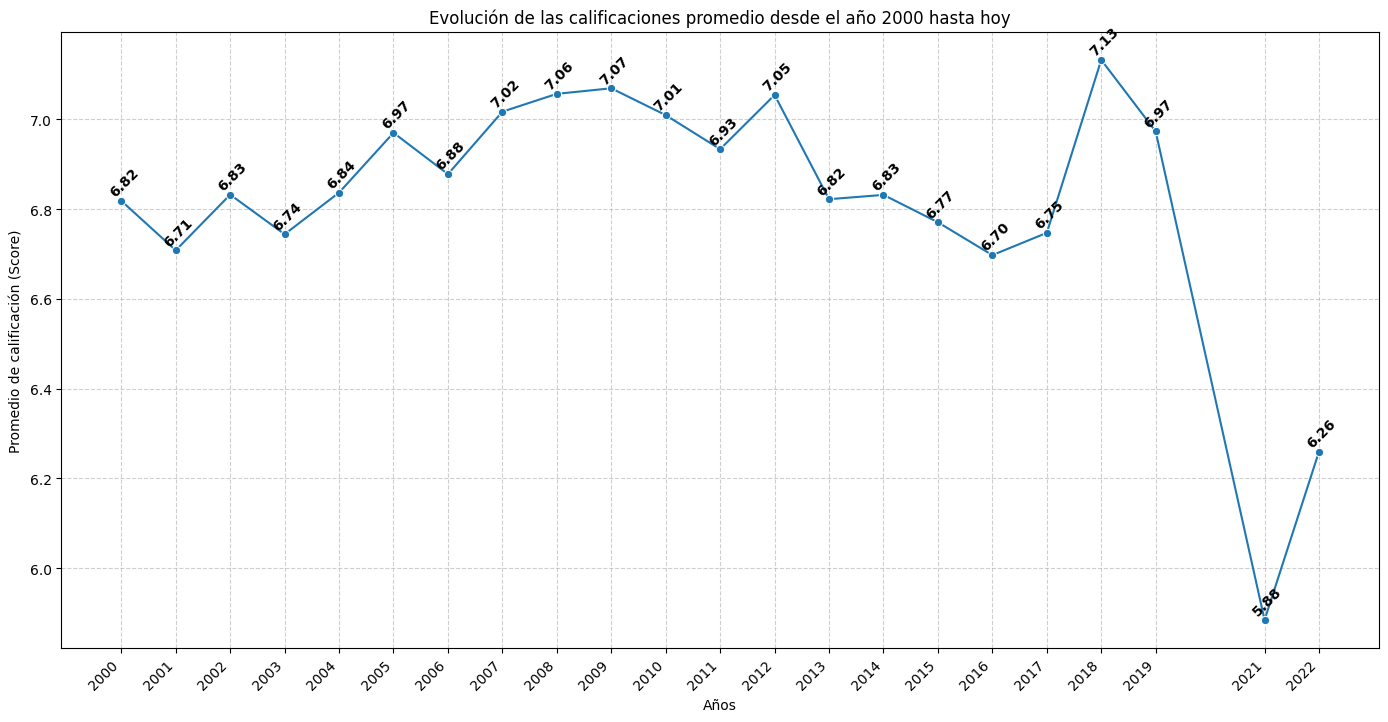

In [87]:
# Obtenciónde df uniendo animes y popularidad
join_animes_popularidad = pd.merge(dic_df['Animes'], dic_df['Popularidad'], on='mal_id', how='inner')
animes_popularidad_mayor_2000 = join_animes_popularidad[(join_animes_popularidad['annio'] >= 2000) & (join_animes_popularidad['score'] < 9999)]
promedio_por_annio = animes_popularidad_mayor_2000.groupby('annio')['score'].mean()
df_promedio_por_anio = promedio_por_annio.reset_index()

# Creación de gráfica
plt.figure(figsize=(17,8))
sns.lineplot(data=df_promedio_por_anio, x='annio', y='score', marker='o')

años_unicos = df_promedio_por_anio['annio'].unique()

plt.xticks(
    ticks=años_unicos, 
    labels=años_unicos,
    rotation=45,  
    ha='right'    
)

plt.title('Evolución de las calificaciones promedio desde el año 2000 hasta hoy')
plt.xlabel('Años')
plt.ylabel('Promedio de calificación (Score)')
plt.grid(True, linestyle='--', alpha=0.6)

for index, row in df_promedio_por_anio.iterrows():
    # Coordenadas X e Y donde se colocará el texto
    x_coord = row['annio']
    y_coord = row['score']
    
    # El valor a mostrar, redondeado a 2 decimales
    valor_texto = f"{y_coord:.2f}"
    
    # Posicionar el texto
    plt.text(
        x=x_coord + 0.05, 
        y=y_coord + 0.01,  # Ajuste (+0.01) para que el texto quede un poco encima del punto
        s=valor_texto, 
        ha='center',       
        fontsize=10,
        weight='bold',
        rotation=45   
    )

plt.show()

* **¿Han aumentado o disminuido la oferta de anime por año y temporada?**

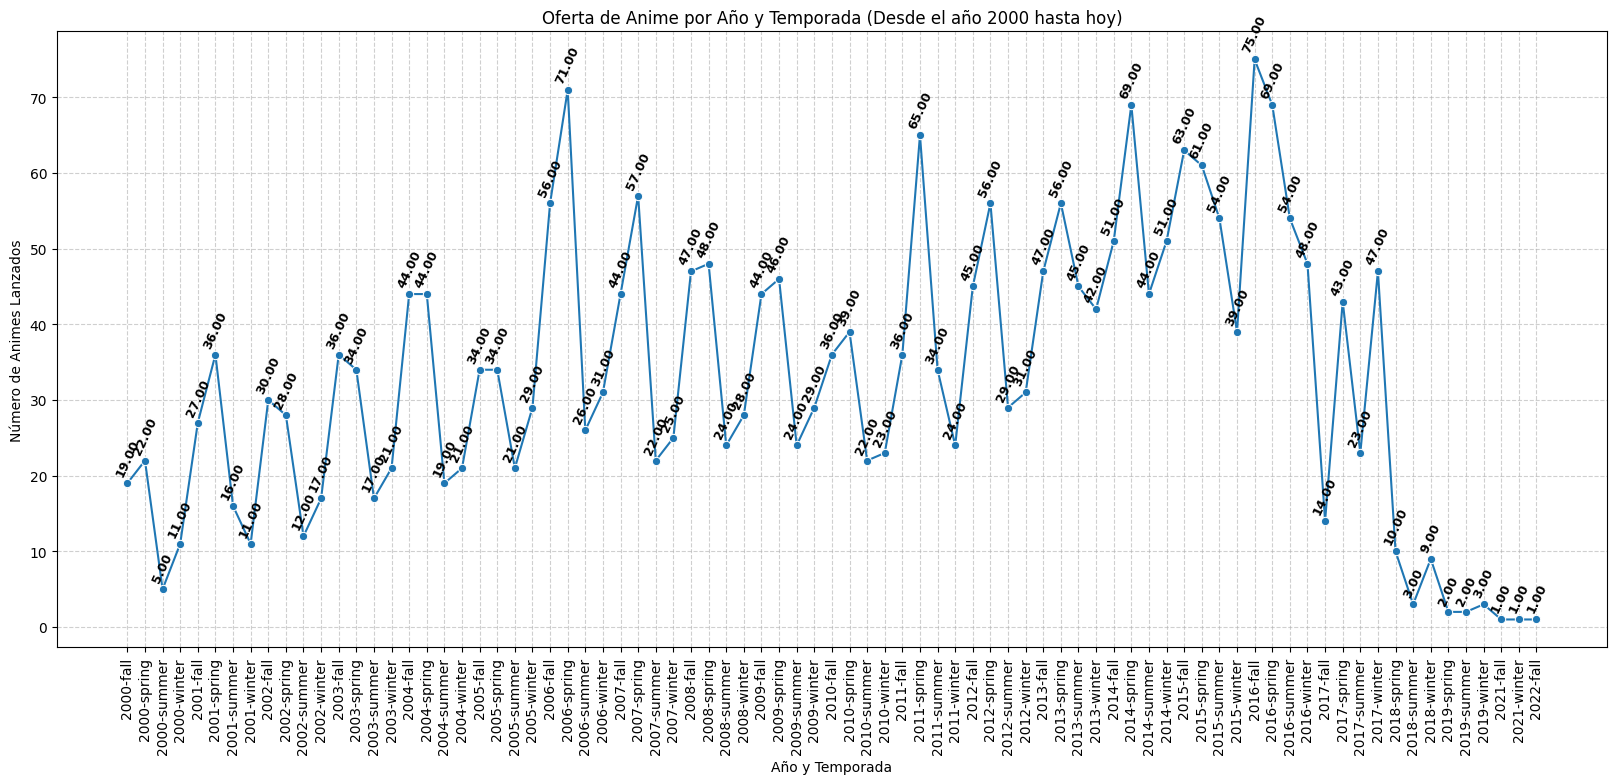

In [74]:

annio_temporada = dic_df['Animes'].groupby(['annio','temporada'])['mal_id'].count()
df_oferta = annio_temporada.to_frame(name='oferta_count').reset_index()
df_oferta = df_oferta[df_oferta['annio'] >= 2000]
# Crear una variable combinada para el eje X
df_oferta['annio_temporada'] = df_oferta['annio'].astype(str) + '-' + df_oferta['temporada']

# Gráfico para ver la tendencia 
plt.figure(figsize=(20, 8))
sns.lineplot(data=df_oferta, x='annio_temporada', y='oferta_count', marker='o')

plt.xticks(rotation=90)
plt.title('Oferta de Anime por Año y Temporada (Desde el año 2000 hasta hoy)')
plt.ylabel('Número de Animes Lanzados')
plt.xlabel('Año y Temporada')
plt.grid(True, linestyle='--', alpha=0.6)

for index, row in df_oferta.iterrows():
    # Coordenadas X e Y donde se colocará el texto
    x_coord = row['annio_temporada']
    y_coord = row['oferta_count']
    
    # El valor a mostrar, redondeado a 2 decimales
    valor_texto = f"{y_coord:.2f}"
    
    # Posicionar el texto
    plt.text(
        x=x_coord, 
        y=y_coord + 1, 
        s=valor_texto, 
        ha='center',       
        fontsize=9,
        weight='bold',
        rotation=65   
    )

plt.show()

#### **2.-Calidad y popularidad**

* **¿Qué géneros tienen mejor desempeño en rating?**

In [91]:
# Unir las tablas 
df_merge = pd.merge(dic_df['Animes'], dic_df['Popularidad'].query('score < 9999'), on='mal_id', how='inner')
anime_populari_anime_generos = pd.merge(df_merge, dic_df['Anime_Generos'], on='mal_id', how='inner')
anime_populari_anime_generos_generos = pd.merge(anime_populari_anime_generos, dic_df['Generos'], on='genero_id', how='inner')

# Agrupar los datos
genero_ranting = anime_populari_anime_generos_generos.groupby('nombre_genero')['score'].mean().reset_index()
genero_ranting['score'] = genero_ranting['score'].round(2)

genero_ranting = genero_ranting.sort_values(by='score', ascending=False)
genero_ranting

,nombre_genero,score
3,Award Winning,7.25
20,Suspense,7.18
14,Mystery,6.98
15,Romance,6.80
6,Drama,6.79
19,Supernatural,6.75
0,Action,6.68
18,Sports,6.66
1,Adventure,6.63
11,Gourmet,6.56


* **¿Existen géneros que dominan en ciertas épocas?**

* **¿Qué diferencia a un anime con rating sobresaliente de uno promedio?**